In [1]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Import the dataframes: 

In [2]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_absolute_otu_5in10percent.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_relative_5in10percent.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_HNA_LNA_5in10percent.tsv', sep= ' ', index_col=0, header=0)

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [3]:
#samples_to_drop = ['Z14055F', 'Z14003F', 'Z14007F', 'Z14023F', 'Z14011F']
#index = target.index.drop(samples_to_drop)

In [4]:
'''Set sample names as index and shuffle data'''
index = data_rel.index


#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [5]:
#Some variables to store information and to create inner and outer CV-folds

#data_rel = data_rel.loc[:, (data_rel != 0).any(axis=0)]
otus = list(data_rel.columns)

#cv_out = 10
cv = 5
#outer_cv = KFold(n_splits=cv_out, shuffle=False)

#otu_scores_cv = pd.DataFrame(columns=otus)
#r2_cv = np.zeros(cv_out)
#thresholds_cv = np.zeros(cv_out)

#pred = pd.Series(index=data_abs.index)
#final_scores = pd.DataFrame(columns=otus)

#thresholds = np.arange(0,1,0.01)
#t = 0

In [6]:
''' Standardize data '''
from analysis_functions import standardize_df
data_stand, scaler = standardize_df(data_rel,otus)

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

**Univariate Feature Selection**: 

Let's compare two methods: 
- f_regression (f-score pearson correlation), 
- Mutual information,  
- (other methods can follow as well). 

In [7]:
f_regr, f_regr_p = f_regression(data_stand.loc[:,otus],hna)
uni_fs = pd.DataFrame(f_regr, index=otus, columns = ['f_regr'])
uni_fs['p-value'] = f_regr_p
uni_fs['mi'] = mutual_info_regression(data_stand.loc[:,otus],hna)
uni_fs.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs.head(10))

,f_regr,p-value,mi
Otu000173,127.229173,2.884081e-22,0.350285
Otu000060,115.530924,8.695835e-21,0.348857
Otu000001,97.366470,2.319832e-18,0.302795
Otu000187,56.199217,3.730353e-12,0.138033
Otu000778,49.827792,4.358961e-11,0.097628
Otu000222,46.874265,1.399116e-10,0.123485
Otu000335,44.398492,3.769799e-10,0.140100
Otu000027,40.865469,1.586087e-09,0.304898
Otu000313,39.857364,2.401842e-09,0.110241
Otu000088,39.375615,2.930984e-09,0.159316


Select otu's based on $p < \text{thr}$: 

In [8]:
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs with p < 0.05: 213
Number of selected OTUs with p < 0.01: 158


What happens when we tune a threshold in function of the f_score: 

In [9]:
from analysis_functions import get_r2_scores
thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['f_regr'], cv)
thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['f_regr'], cv)

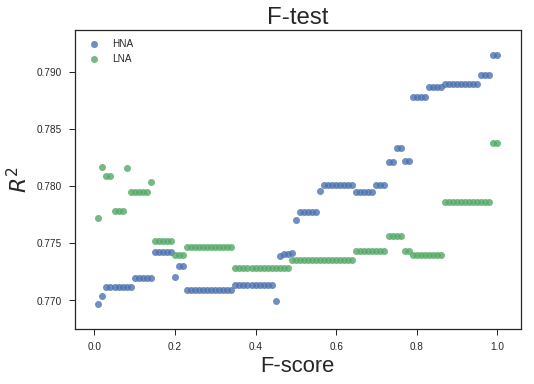

In [10]:
plt.figure()
sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
plt.xlabel('F-score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('F-test', size=24)
plt.legend()
plt.show()

In [11]:
#uni_fs.sort_values(ascending=False,inplace=True, by='mi')
#display(uni_fs.head(10))
#thr_otu_mi_hna, r2_otu_mi_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['mi'], cv)
#thr_otu_mi_lna, r2_otu_mi_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['mi'], cv)

In [12]:
#plt.figure()
#sns.regplot(x=thr_otu_mi_hna,y=r2_otu_mi_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_mi_lna,y=r2_otu_mi_lna, fit_reg=False, label='LNA')
#plt.xlabel('MI', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('Mutual Information', size=24)
#plt.legend()
#plt.show()

In [13]:
from analysis_functions import get_lassoCV_alpha

alpha = get_lassoCV_alpha(data_stand.loc[:,otus],hna,otus,cv)
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], hna, alpha), index=otus, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True, by='score')

thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores, cv)
thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores, cv)

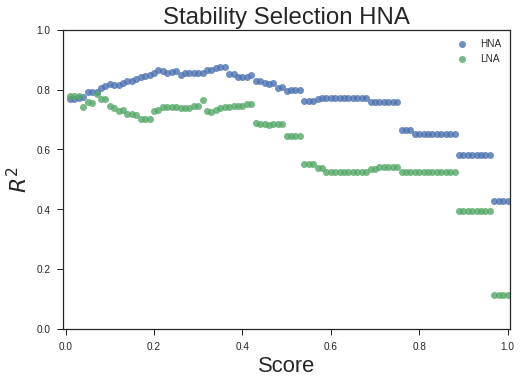

In [14]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection HNA', size=24)
plt.show()

In [15]:
r2_final = r2_otu_scores_hna.max()
thr = thr_otu_scores_hna[r2_otu_scores_hna.argmax()]
print('R²_cv(hna): ' + str(r2_final) )
print('Threshold score: ' + str(thr))

R²_cv(hna): 0.876141512656
Threshold score: 0.36


In [16]:
otu_scores = otu_scores.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores =  otu_scores.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores.to_csv('Final/hnascores_otus_5seq10_rel.csv')

In [17]:
otu_scores_selected = otu_scores[otu_scores.score.values>thr]
selected_otus = otu_scores_selected.index
otu_scores_selected.to_csv('Final/hnascores_otus_tuned_thr_'+str(thr)+'_5seq10_rel.csv')
display(otu_scores_selected.head(10))
print('Size list selected OTUs: ' + str(len(selected_otus)))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000173,0.996667,9202.636543,1.868851,0.001316,1.673870
Otu000060,0.956667,27431.752891,1.430959,0.004059,1.039940
Otu000313,0.873333,2917.175675,2.192946,0.000389,1.931977
Otu000264,0.780000,4876.450423,3.555170,0.001022,3.016365
Otu000001,0.746667,388884.795943,0.710040,0.099741,0.624193
Otu000778,0.700000,1003.428651,3.139226,0.000126,2.437522
Otu000682,0.676667,1400.166800,4.290562,0.000155,3.962109
Otu000154,0.616667,4420.233668,1.423808,0.001512,2.476511
Otu000242,0.576667,5151.362021,3.267847,0.000738,2.498881
Otu001038,0.570000,778.104645,2.538653,0.000162,2.600144


Size list selected OTUs: 41


In [18]:
print('R²_cv of HNA-selected OTUs in function of LNA: ' + str(r2_otu_scores_lna[r2_otu_scores_hna.argmax()]) )

R²_cv of HNA-selected OTUs in function of LNA: 0.743252127057


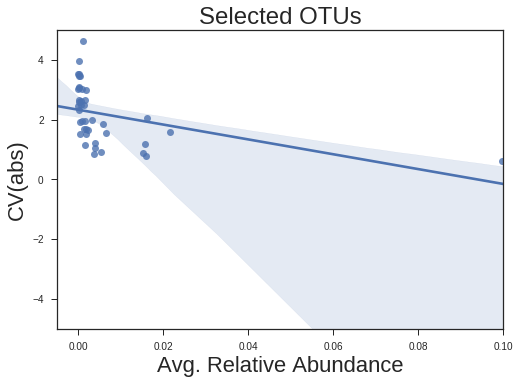

In [19]:
plt.figure()
sns.regplot(x='abun_rel_mean',y='abun_rel_CV', data=otu_scores_selected)
plt.axis([-0.005,0.1,-5,5])
plt.xlabel('Avg. Relative Abundance', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.title('Selected OTUs', size=24)
plt.show()

In [20]:
#optimal_scores.to_csv('HNA_selectedOTUs_stand_abun_remov' + str(abun)+'_R2'+str(r2_final)+'.csv')

**Second goal**: Can we use the same pipeline to predict the _LNA_-counts? 

In [21]:
f_regr_lna, f_regr_p_lna = f_regression(data_stand.loc[:,otus],lna)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p_lna
uni_fs_lna['mi'] = mutual_info_regression(data_stand.loc[:,otus],lna)
uni_fs_lna.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs_lna.head(10))

,f_regr,p-value,mi
Otu000060,113.697499,1.502530e-20,0.355109
Otu000027,105.881246,1.612656e-19,0.618954
Otu000043,68.032590,4.703819e-14,0.395461
Otu000317,61.754026,4.647576e-13,0.214533
Otu000271,61.642448,4.843561e-13,0.311079
Otu000108,59.526492,1.064422e-12,0.372395
Otu000113,59.268214,1.172425e-12,0.273665
Otu000017,55.704790,4.502159e-12,0.208475
Otu000119,54.864372,6.204254e-12,0.260431
Otu000074,54.129522,8.221068e-12,0.214840


In [22]:
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f_lna)))

Number of selected OTUs with p < 0.05: 282
Number of selected OTUs with p < 0.01: 229


In [23]:
thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs_lna['f_regr'], cv)
thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs_lna['f_regr'], cv)

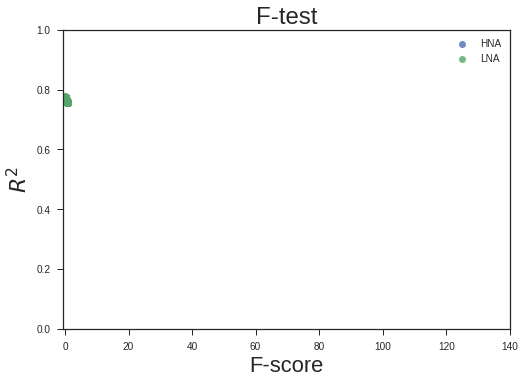

In [24]:
plt.figure()
sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
plt.axis([-0.5,140,0,1])
plt.xlabel('F-score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('F-test', size=24)
plt.legend()
plt.show()

In [25]:
alpha = get_lassoCV_alpha(data_stand.loc[:,otus],lna,otus,cv)
otu_scores_lna = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], lna, alpha), index=otus, columns=['score'])
otu_scores_lna.sort_values(ascending=False, inplace=True, by='score')

thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores_lna, cv)
thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores_lna, cv)

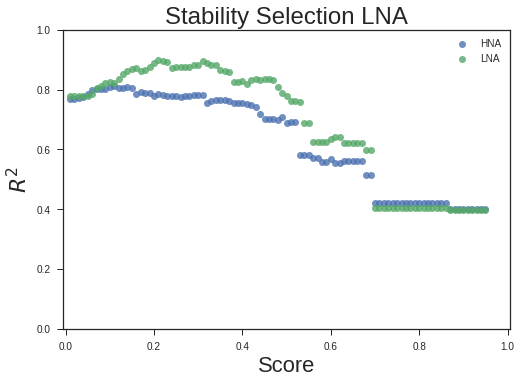

In [26]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection LNA', size=24)
plt.show()

In [27]:
r2_final = r2_otu_scores_lna.max()
thr_lna = thr_otu_scores_lna[r2_otu_scores_lna.argmax()]
print('R²_cv(lna): ' + str(r2_final) )
print('Threshold score: ' + str(thr_lna))

R²_cv(lna): 0.898149569018
Threshold score: 0.21


In [28]:
otu_scores_lna = otu_scores_lna.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores_lna =  otu_scores_lna.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores_lna.to_csv('Final/lnascores_otus_5seq10_rel.csv')


In [36]:
otu_scores_selected_lna = otu_scores_lna[otu_scores_lna.score.values>thr_lna]
selected_otus_lna = otu_scores_selected_lna.index
print('Size list selected OTUs: ' + str(len(selected_otus_lna)))
otu_scores_selected_lna.to_csv('Final/lnascores_otus_tuned_thr_'+str(thr_lna)+'_5seq10_rel.csv')
display(otu_scores_selected_lna.head(10))

Size list selected OTUs: 124


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000060,0.943333,27431.752891,1.430959,0.004059,1.039940
Otu000287,0.853333,6997.545419,4.951683,0.001314,4.287124
Otu000075,0.690000,19069.997115,1.299822,0.006643,1.559337
Otu000113,0.683333,6981.672822,2.487085,0.000863,2.390282
Otu000313,0.670000,2917.175675,2.192946,0.000389,1.931977
Otu000117,0.620000,1316.683259,3.842288,0.000220,3.069271
Otu000024,0.593333,85415.949950,1.128066,0.015264,0.885935
Otu000279,0.586667,4272.285756,4.426146,0.000644,2.633250
Otu000335,0.563333,6536.720753,2.369310,0.000949,1.952866
Otu000074,0.550000,13440.587905,0.795363,0.003679,0.856972


In [30]:
print('R²_cv of LNA-selected OTUs in function of HNA: ' + str(r2_otu_scores_hna[r2_otu_scores_lna.argmax()]) )

R²_cv of LNA-selected OTUs in function of HNA: 0.786914724996


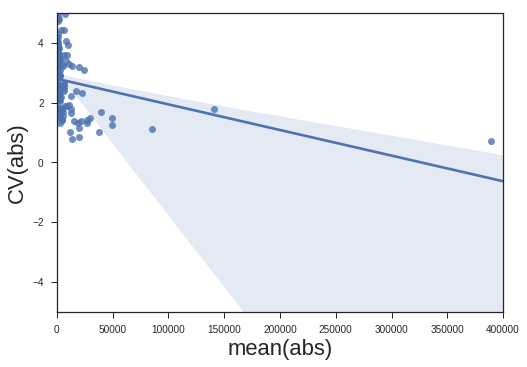

In [31]:
plt.figure()
sns.regplot(x='abun_abs_mean',y='abun_abs_CV', data=otu_scores_selected_lna)
plt.axis([0,400000,-5,5])
plt.xlabel('mean(abs)', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.show()

Let's compare the HNA- and LNA-lists, which OTU's are shared (_common_) and which are only part of the HNA- or LNA subset?: 

In [32]:
idx_hna = otu_scores_selected.index.difference(otu_scores_selected_lna.index)
idx_lna = otu_scores_selected_lna.index.difference(otu_scores_selected.index)
idx_common = otu_scores_selected.drop(idx_hna).index
pd.Series(idx_common).to_csv('commonOTU_HNALNA_rel.csv')
print('Size subset OTUs only related to HNA: ' + str(len(idx_hna)) + '; opposed to total size: ' + str(len(otu_scores_selected)))
print('Size subset OTUs only related to LNA: ' + str(len(idx_lna)) + '; opposed to total size: ' + str(len(otu_scores_selected_lna)))
print('Size subset OTUs related to both: ' + str(len(idx_common)))

display(otu_scores_selected_lna.loc[idx_common,:])
#data_abs_raw = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
#data_abs_raw = data_abs_raw.loc[index,:]
#display(data_abs_raw.loc[:,idx_hna].sum(axis=1).values/hna.values)

Size subset OTUs only related to HNA: 12; opposed to total size: 41
Size subset OTUs only related to LNA: 95; opposed to total size: 124
Size subset OTUs related to both: 29


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000173,0.516667,9202.636543,1.868851,0.001316,1.673870
Otu000060,0.943333,27431.752891,1.430959,0.004059,1.039940
Otu000313,0.670000,2917.175675,2.192946,0.000389,1.931977
Otu000001,0.310000,388884.795943,0.710040,0.099741,0.624193
Otu000778,0.330000,1003.428651,3.139226,0.000126,2.437522
Otu000682,0.486667,1400.166800,4.290562,0.000155,3.962109
Otu000154,0.436667,4420.233668,1.423808,0.001512,2.476511
Otu000242,0.336667,5151.362021,3.267847,0.000738,2.498881
Otu001038,0.523333,778.104645,2.538653,0.000162,2.600144
Otu000335,0.563333,6536.720753,2.369310,0.000949,1.952866


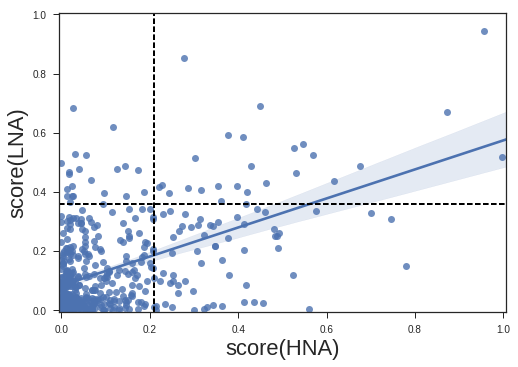

In [33]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=otu_scores_lna.loc[otu_scores.index,'score'])
plt.axis([-0.005,1.005,-0.005,1.005])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('score(LNA)', size=22)
plt.yticks(size=10)
plt.axhline(y=thr, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.show()

This figure shows 4 area's: 
- (left top corner): OTU's selected solely in function of **LNA**-dynamics, 
- (right top corner): OTU's selected in function of both **HNA**- and **LNA**-dynamics, 
- (left bottom corner): OTU's that are _not_ selected, 
- (right bottom corner): OTU's selected solely in function of **HNA**-dynamics. 

Univariate vs. Stability selection

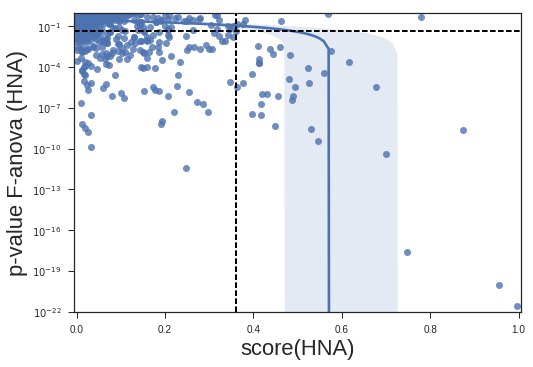

In [34]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=uni_fs.loc[otu_scores.index,'p-value'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('p-value F-anova (HNA)', size=22)
plt.yticks(size=10)
plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr, linewidth=2, linestyle='--', color = 'k')
plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

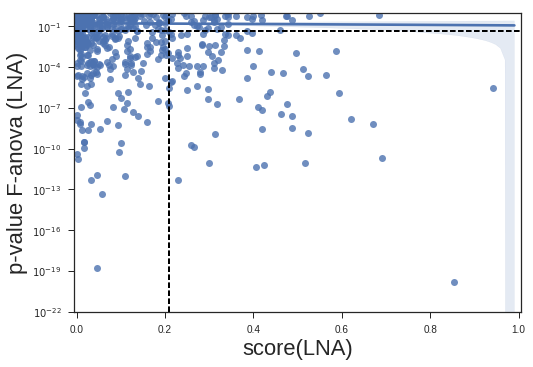

In [35]:
plt.figure()
sns.regplot(x=otu_scores_lna.loc[:,'score'],y=uni_fs_lna.loc[otu_scores.index,'p-value'])
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('p-value F-anova (LNA)', size=22)
plt.yticks(size=10)
plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

This analysis shows that the HNA/LNA dynamics cannot solely be attributed to OTU's that are present in the respective cloud; this is also clear from the mutual correlation between HNA- and LNA-counts ( $\rho(\text{HNA,LNA}) = 0.75$ ). 

I see two reasons for this: 
- Some OTU's are simply present in the two clouds; 
- Some HNA-OTU's interact with LNA-OTU's and vice versa. 